In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook explores one cycle policy
ref : https://github.com/titu1994/keras-one-cycle

In [2]:
import os
import shutil
import random
import time
import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers,models,utils,optimizers,regularizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard

from util.clr import OneCycleLR
from util.custom_callbacks import SkipLoggerCallback
from util.learningratefinder import LearningRateFinder

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16():
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

#### Optimal Batch Size

In [96]:
batch_sizes = [32,64,128,256,512,1024]
MIN_LR = 1e-7
MAX_LR = 1e+1
lr_dict = {}

In [97]:
for batch_size in batch_sizes:
    print('working with batch size : %f' % batch_size)
    print('-'*120)
    
    model = define_model_architecture_64_32_16()
    sgd_optimizer = optimizers.SGD(lr=6e-3, momentum=0.95)
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
   
    lrf = LearningRateFinder(model)
    lrf.find(train_batches,MIN_LR, MAX_LR, sampleSize = train_batches.samples, stepsPerEpoch=train_batches.samples/batch_size,
             batchSize=batch_size, verbose=1)
    
    lr_dict[str(batch_size)] = lrf.get_session_stats()

working with batch size : 32.000000
------------------------------------------------------------------------------------------------------------------------
Epoch 1/32
58/57 [==============================] - 12s 215ms/step - loss: 1.0310 - accuracy: 0.4934
Epoch 2/32
58/57 [==============================] - 12s 214ms/step - loss: 1.0167 - accuracy: 0.4934
Epoch 3/32
58/57 [==============================] - 12s 215ms/step - loss: 1.0064 - accuracy: 0.4934
Epoch 4/32
58/57 [==============================] - 13s 216ms/step - loss: 0.9794 - accuracy: 0.4934
Epoch 5/32
58/57 [==============================] - 12s 214ms/step - loss: 0.9521 - accuracy: 0.4934
Epoch 6/32
58/57 [==============================] - 12s 213ms/step - loss: 0.8922 - accuracy: 0.4934
Epoch 7/32
58/57 [==============================] - 12s 214ms/step - loss: 0.8357 - accuracy: 0.4940
Epoch 8/32
58/57 [==============================] - 12s 212ms/step - loss: 0.7784 - accuracy: 0.4934
Epoch 9/32
58/57 [=================

15/14 [===============================] - 4s 236ms/step - loss: 0.6439 - accuracy: 0.6646
Epoch 62/128
15/14 [===============================] - 3s 218ms/step - loss: 0.6064 - accuracy: 0.6842
Epoch 63/128
15/14 [===============================] - 3s 220ms/step - loss: 0.5947 - accuracy: 0.6812
Epoch 64/128
15/14 [===============================] - 3s 201ms/step - loss: 0.6827 - accuracy: 0.6250
Epoch 65/128
15/14 [===============================] - 3s 213ms/step - loss: 0.6027 - accuracy: 0.6667
Epoch 66/128
15/14 [===============================] - 3s 205ms/step - loss: 0.6125 - accuracy: 0.6583
Epoch 67/128
15/14 [===============================] - 3s 217ms/step - loss: 0.5824 - accuracy: 0.6938
Epoch 68/128
15/14 [===============================] - 3s 223ms/step - loss: 0.6488 - accuracy: 0.6583
Epoch 69/128
15/14 [===============================] - 4s 254ms/step - loss: 0.7146 - accuracy: 0.5813
Epoch 70/128
15/14 [===============================] - 3s 200ms/step - loss: 0.6956 - 

8/7 [=================================] - 2s 188ms/step - loss: 0.6372 - accuracy: 0.6523
Epoch 97/256
8/7 [=================================] - 2s 237ms/step - loss: 0.6289 - accuracy: 0.6562
Epoch 98/256
8/7 [=================================] - 2s 196ms/step - loss: 0.6124 - accuracy: 0.6680
Epoch 99/256
8/7 [=================================] - 2s 205ms/step - loss: 0.6440 - accuracy: 0.6406
Epoch 100/256
8/7 [=================================] - 2s 249ms/step - loss: 0.6400 - accuracy: 0.6367
Epoch 101/256
8/7 [=================================] - 2s 202ms/step - loss: 0.6392 - accuracy: 0.6289
Epoch 102/256
8/7 [=================================] - 2s 210ms/step - loss: 0.6513 - accuracy: 0.6445
Epoch 103/256
8/7 [=================================] - 2s 223ms/step - loss: 0.6149 - accuracy: 0.6719
Epoch 104/256
8/7 [=================================] - 2s 207ms/step - loss: 0.6469 - accuracy: 0.6172
Epoch 105/256
8/7 [=================================] - 2s 223ms/step - loss: 0.6

Epoch 175/256
8/7 [=================================] - 2s 212ms/step - loss: 0.7122 - accuracy: 0.4612
Epoch 176/256
8/7 [=================================] - 2s 204ms/step - loss: 0.6951 - accuracy: 0.4922
Epoch 177/256
8/7 [=================================] - 2s 212ms/step - loss: 0.7074 - accuracy: 0.4766
Epoch 178/256
8/7 [=================================] - 2s 235ms/step - loss: 0.6969 - accuracy: 0.4609
Epoch 179/256
8/7 [=================================] - 2s 208ms/step - loss: 0.6963 - accuracy: 0.5156
Epoch 180/256
8/7 [=================================] - 2s 209ms/step - loss: 0.7030 - accuracy: 0.4805
Epoch 181/256
8/7 [=================================] - 2s 227ms/step - loss: 0.7151 - accuracy: 0.5039
Epoch 182/256
8/7 [=================================] - 1s 185ms/step - loss: 0.7154 - accuracy: 0.5000
Epoch 183/256
8/7 [=================================] - 2s 235ms/step - loss: 0.6911 - accuracy: 0.5586
Epoch 184/256
8/7 [=================================] - 2s 190ms

4/3 [=================================] - 1s 223ms/step - loss: 0.7046 - accuracy: 0.5625
Epoch 114/512
4/3 [=================================] - 1s 344ms/step - loss: 0.7442 - accuracy: 0.4688
Epoch 115/512
4/3 [=================================] - 1s 196ms/step - loss: 0.7224 - accuracy: 0.5312
Epoch 116/512
4/3 [=================================] - 1s 206ms/step - loss: 0.7635 - accuracy: 0.4531
Epoch 117/512
4/3 [=================================] - 1s 243ms/step - loss: 0.7183 - accuracy: 0.5391
Epoch 118/512
4/3 [=================================] - 1s 202ms/step - loss: 0.7167 - accuracy: 0.5156
Epoch 119/512
4/3 [=================================] - 1s 189ms/step - loss: 0.7291 - accuracy: 0.5156
Epoch 120/512
4/3 [=================================] - 1s 151ms/step - loss: 0.7605 - accuracy: 0.4327
Epoch 121/512
4/3 [=================================] - 1s 178ms/step - loss: 0.7301 - accuracy: 0.4844
Epoch 122/512
4/3 [=================================] - 1s 248ms/step - loss: 

Epoch 192/512
4/3 [=================================] - 1s 196ms/step - loss: 0.6845 - accuracy: 0.5469
Epoch 193/512
4/3 [=================================] - 1s 187ms/step - loss: 0.6766 - accuracy: 0.6016
Epoch 194/512
4/3 [=================================] - 1s 178ms/step - loss: 0.6842 - accuracy: 0.5781
Epoch 195/512
4/3 [=================================] - 1s 179ms/step - loss: 0.6844 - accuracy: 0.5312
Epoch 196/512
4/3 [=================================] - 1s 201ms/step - loss: 0.6677 - accuracy: 0.6016
Epoch 197/512
4/3 [=================================] - 1s 231ms/step - loss: 0.6660 - accuracy: 0.5781
Epoch 198/512
4/3 [=================================] - 1s 212ms/step - loss: 0.6788 - accuracy: 0.5000
Epoch 199/512
4/3 [=================================] - 1s 244ms/step - loss: 0.6728 - accuracy: 0.5625
Epoch 200/512
4/3 [=================================] - 1s 236ms/step - loss: 0.6731 - accuracy: 0.5625
Epoch 201/512
4/3 [=================================] - 1s 267ms

Epoch 349/512
4/3 [=================================] - 1s 238ms/step - loss: 0.6980 - accuracy: 0.4688
Epoch 350/512
4/3 [=================================] - 1s 215ms/step - loss: 0.6884 - accuracy: 0.5625
Epoch 351/512
4/3 [=================================] - 1s 191ms/step - loss: 0.7350 - accuracy: 0.4766
Epoch 352/512
4/3 [=================================] - 1s 183ms/step - loss: 0.6919 - accuracy: 0.5312
Epoch 353/512
4/3 [=================================] - 1s 211ms/step - loss: 0.6982 - accuracy: 0.4922
Epoch 354/512
4/3 [=================================] - 1s 169ms/step - loss: 0.6899 - accuracy: 0.5673
Epoch 355/512
4/3 [=================================] - 1s 257ms/step - loss: 0.7075 - accuracy: 0.4531
Epoch 356/512
4/3 [=================================] - 1s 234ms/step - loss: 0.6992 - accuracy: 0.4531
Epoch 357/512
4/3 [=================================] - 1s 210ms/step - loss: 0.7006 - accuracy: 0.5078
Epoch 358/512
4/3 [=================================] - 1s 208ms

2/1 [=================================] - 0s 222ms/step - loss: 0.7032 - accuracy: 0.4844
Epoch 45/1024
2/1 [=================================] - 0s 197ms/step - loss: 0.7131 - accuracy: 0.4219
Epoch 46/1024
2/1 [=================================] - 1s 256ms/step - loss: 0.7123 - accuracy: 0.4688
Epoch 47/1024
2/1 [=================================] - 0s 191ms/step - loss: 0.7135 - accuracy: 0.3906
Epoch 48/1024
2/1 [=================================] - 0s 235ms/step - loss: 0.7019 - accuracy: 0.4688
Epoch 49/1024
2/1 [=================================] - 1s 286ms/step - loss: 0.7104 - accuracy: 0.4219
Epoch 50/1024
2/1 [=================================] - 0s 179ms/step - loss: 0.7007 - accuracy: 0.4688
Epoch 51/1024
2/1 [=================================] - 0s 175ms/step - loss: 0.7175 - accuracy: 0.3438
Epoch 52/1024
2/1 [=================================] - 0s 248ms/step - loss: 0.7002 - accuracy: 0.4688
Epoch 53/1024
2/1 [=================================] - 0s 132ms/step - loss: 

2/1 [=================================] - 0s 169ms/step - loss: 0.7113 - accuracy: 0.3594
Epoch 201/1024
2/1 [=================================] - 0s 212ms/step - loss: 0.6809 - accuracy: 0.6406
Epoch 202/1024
2/1 [=================================] - 0s 157ms/step - loss: 0.7204 - accuracy: 0.3438
Epoch 203/1024
2/1 [=================================] - 0s 201ms/step - loss: 0.7206 - accuracy: 0.4062
Epoch 204/1024
2/1 [=================================] - 0s 206ms/step - loss: 0.7185 - accuracy: 0.3906
Epoch 205/1024
2/1 [=================================] - 0s 202ms/step - loss: 0.7016 - accuracy: 0.4688
Epoch 206/1024
2/1 [=================================] - 1s 264ms/step - loss: 0.6910 - accuracy: 0.5000
Epoch 207/1024
2/1 [=================================] - 0s 204ms/step - loss: 0.7137 - accuracy: 0.4375
Epoch 208/1024
2/1 [=================================] - 0s 206ms/step - loss: 0.7004 - accuracy: 0.5312
Epoch 209/1024
2/1 [=================================] - 0s 196ms/step

2/1 [=================================] - 0s 197ms/step - loss: 0.6957 - accuracy: 0.5469
Epoch 357/1024
2/1 [=================================] - 0s 217ms/step - loss: 0.6988 - accuracy: 0.5156
Epoch 358/1024
2/1 [=================================] - 0s 145ms/step - loss: 0.6747 - accuracy: 0.6250
Epoch 359/1024
2/1 [=================================] - 0s 176ms/step - loss: 0.6804 - accuracy: 0.5625
Epoch 360/1024
2/1 [=================================] - 0s 196ms/step - loss: 0.6681 - accuracy: 0.6406
Epoch 361/1024
2/1 [=================================] - 0s 164ms/step - loss: 0.6818 - accuracy: 0.6250
Epoch 362/1024
2/1 [=================================] - 0s 209ms/step - loss: 0.6847 - accuracy: 0.5625
Epoch 363/1024
2/1 [=================================] - 0s 194ms/step - loss: 0.6845 - accuracy: 0.5000
Epoch 364/1024
2/1 [=================================] - 1s 273ms/step - loss: 0.6788 - accuracy: 0.5156
Epoch 365/1024
2/1 [=================================] - 0s 210ms/step

2/1 [=================================] - 1s 261ms/step - loss: 0.6553 - accuracy: 0.6719
Epoch 513/1024
2/1 [=================================] - 0s 163ms/step - loss: 0.6395 - accuracy: 0.7031
Epoch 514/1024
2/1 [=================================] - 0s 246ms/step - loss: 0.6270 - accuracy: 0.6406
Epoch 515/1024
2/1 [=================================] - 0s 129ms/step - loss: 0.7118 - accuracy: 0.5750
Epoch 516/1024
2/1 [=================================] - 0s 207ms/step - loss: 0.7162 - accuracy: 0.5625
Epoch 517/1024
2/1 [=================================] - 0s 179ms/step - loss: 0.6058 - accuracy: 0.7500
Epoch 518/1024
2/1 [=================================] - 0s 240ms/step - loss: 0.5399 - accuracy: 0.6875
Epoch 519/1024
2/1 [=================================] - 0s 154ms/step - loss: 0.7107 - accuracy: 0.5938
Epoch 520/1024
2/1 [=================================] - 0s 179ms/step - loss: 0.6845 - accuracy: 0.6250
Epoch 521/1024
2/1 [=================================] - 0s 202ms/step

2/1 [=================================] - 0s 212ms/step - loss: 0.7097 - accuracy: 0.6875
Epoch 669/1024
2/1 [=================================] - 0s 209ms/step - loss: 0.5890 - accuracy: 0.6875
Epoch 670/1024
2/1 [=================================] - 0s 203ms/step - loss: 0.6592 - accuracy: 0.6094
Epoch 671/1024
2/1 [=================================] - 0s 211ms/step - loss: 0.6354 - accuracy: 0.6250
Epoch 672/1024
2/1 [=================================] - 1s 308ms/step - loss: 0.6385 - accuracy: 0.5781
Epoch 673/1024
2/1 [=================================] - 0s 212ms/step - loss: 0.6142 - accuracy: 0.6719
Epoch 674/1024
2/1 [=================================] - 0s 202ms/step - loss: 0.6780 - accuracy: 0.5469
Epoch 675/1024
2/1 [=================================] - 0s 250ms/step - loss: 0.6225 - accuracy: 0.6406
Epoch 676/1024
2/1 [=================================] - 0s 185ms/step - loss: 0.6092 - accuracy: 0.6406
Epoch 677/1024
2/1 [=================================] - 0s 229ms/step

2/1 [=================================] - 0s 154ms/step - loss: 0.7405 - accuracy: 0.4688
Epoch 825/1024
2/1 [=================================] - 0s 149ms/step - loss: 0.7899 - accuracy: 0.4062
Epoch 826/1024
2/1 [=================================] - 0s 242ms/step - loss: 0.8329 - accuracy: 0.5156
Epoch 827/1024
2/1 [=================================] - 1s 263ms/step - loss: 0.7795 - accuracy: 0.4531
Epoch 828/1024
2/1 [=================================] - 1s 270ms/step - loss: 0.7338 - accuracy: 0.5469
Epoch 829/1024
2/1 [=================================] - 0s 183ms/step - loss: 0.7063 - accuracy: 0.5156
Epoch 830/1024
2/1 [=================================] - 0s 237ms/step - loss: 0.7047 - accuracy: 0.5000
Epoch 831/1024
2/1 [=================================] - 1s 285ms/step - loss: 0.6060 - accuracy: 0.7031
Epoch 832/1024
2/1 [=================================] - 0s 218ms/step - loss: 0.9469 - accuracy: 0.4375
Epoch 833/1024
2/1 [=================================] - 0s 145ms/step

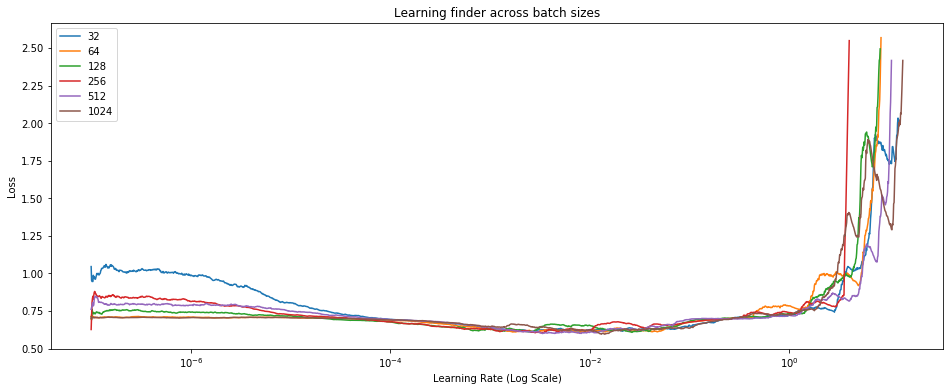

In [98]:
plt.figure(num=None, figsize=(16, 6))

for batch_size, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0], lr_losses[1], label= batch_size)

plt.legend()
plt.title('Learning finder across batch sizes')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

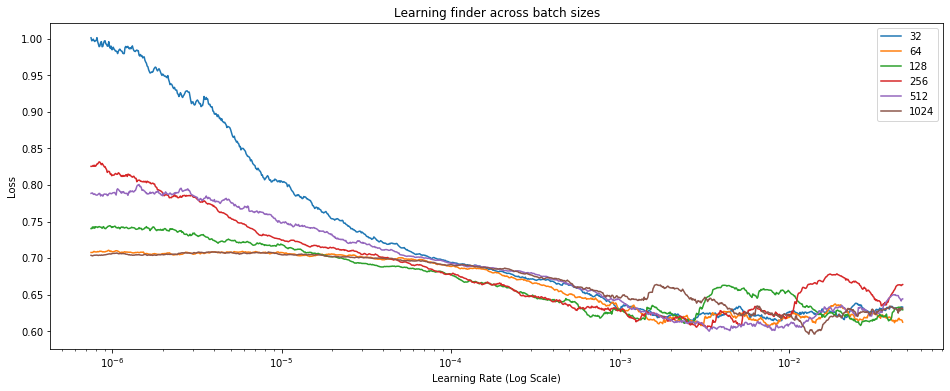

In [99]:
plt.figure(num=None, figsize=(16, 6))

for batch_size, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0][200:1300], lr_losses[1][200:1300], label= batch_size)

plt.legend()
plt.title('Learning finder across batch sizes')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

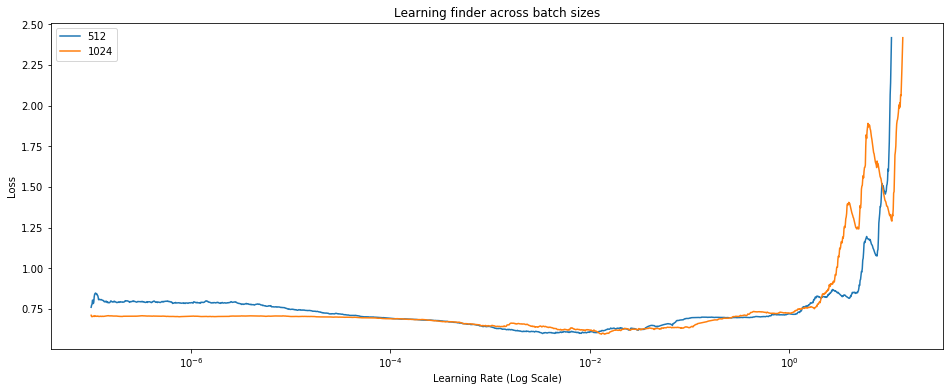

In [179]:
plt.figure(num=None, figsize=(16, 6))

for batch_size, lr_losses in lr_dict.items():
    if batch_size in ['512','1024']:
        axes = plt.plot(lr_losses[0], lr_losses[1], label= batch_size)

plt.legend()
plt.title('Learning finder across batch sizes')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
ax = plt.gca()
plt.show()

1. Batch Size 32 , min_lr = 2.041943e-06,  max_lr = 0.0025732403
2. Batch Size 64 , min_lr = 9.320351e-05,  max_lr = 0.0018466117 
3. Batch Size 128, min_lr = 2.2579368e-06, max_lr = 0.0028454333 
4. Batch Size 256, min_lr = 2.6255118e-06, max_lr = 0.00365863183
5. Batch Size 512, min_lr = 2.041943e-06,  max_lr = 0.0049467864 
6. Batch Size 1024, min_lr = 1e-4, max_lr = 0.012857906

### Optimal momentum

In [185]:
momentum_list = [0.8, 0.85, 0.9, 0.95, 0.99]
batch_size = 512
MIN_LR = 2.041943e-06
MAX_LR = 0.0049467864 
lr_dict = {}

In [186]:
for momentum_i in momentum_list:
    print('working with momentum : %f' % momentum_i)
    print('-'*120)
    
    model = define_model_architecture_64_32_16()
    sgd_optimizer = optimizers.SGD(lr=6e-3, momentum=momentum_i)
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
   
    lrf = LearningRateFinder(model)
    lrf.find(train_batches,MIN_LR, MAX_LR, sampleSize = train_batches.samples, stepsPerEpoch=train_batches.samples/batch_size,
             batchSize=batch_size, verbose=1)
    
    lr_dict[str(momentum_i)] = lrf.get_session_stats()
    print('-'*120)

working with momentum : 0.800000
------------------------------------------------------------------------------------------------------------------------
Epoch 1/512
4/3 [=================================] - 1s 198ms/step - loss: 0.7824 - accuracy: 0.5703
Epoch 2/512
4/3 [=================================] - 1s 220ms/step - loss: 0.9135 - accuracy: 0.4297
Epoch 3/512
4/3 [=================================] - 1s 245ms/step - loss: 0.8145 - accuracy: 0.5078
Epoch 4/512
4/3 [=================================] - 1s 203ms/step - loss: 0.7936 - accuracy: 0.5234
Epoch 5/512
4/3 [=================================] - 1s 189ms/step - loss: 0.8421 - accuracy: 0.5078
Epoch 6/512
4/3 [=================================] - 1s 190ms/step - loss: 0.8037 - accuracy: 0.5078
Epoch 7/512
4/3 [=================================] - 1s 195ms/step - loss: 0.8445 - accuracy: 0.4844
Epoch 8/512
4/3 [=================================] - 1s 198ms/step - loss: 0.7900 - accuracy: 0.5312
Epoch 9/512
4/3 [=============

4/3 [=================================] - 1s 184ms/step - loss: 0.7012 - accuracy: 0.4453
Epoch 159/512
4/3 [=================================] - 1s 209ms/step - loss: 0.7055 - accuracy: 0.5078
Epoch 160/512
4/3 [=================================] - 1s 207ms/step - loss: 0.7230 - accuracy: 0.4453
Epoch 161/512
4/3 [=================================] - 1s 230ms/step - loss: 0.7018 - accuracy: 0.5000
Epoch 162/512
4/3 [=================================] - 1s 260ms/step - loss: 0.7121 - accuracy: 0.4766
Epoch 163/512
4/3 [=================================] - 1s 228ms/step - loss: 0.7053 - accuracy: 0.4688
Epoch 164/512
4/3 [=================================] - 1s 241ms/step - loss: 0.7055 - accuracy: 0.4297
Epoch 165/512
4/3 [=================================] - 1s 186ms/step - loss: 0.7093 - accuracy: 0.4531
Epoch 166/512
4/3 [=================================] - 1s 237ms/step - loss: 0.7017 - accuracy: 0.5000
Epoch 167/512
4/3 [=================================] - 1s 244ms/step - loss: 

Epoch 237/512
4/3 [=================================] - 1s 194ms/step - loss: 0.6846 - accuracy: 0.5547
Epoch 238/512
4/3 [=================================] - 1s 226ms/step - loss: 0.6844 - accuracy: 0.5234
Epoch 239/512
4/3 [=================================] - 1s 265ms/step - loss: 0.6847 - accuracy: 0.5469
Epoch 240/512
4/3 [=================================] - 1s 224ms/step - loss: 0.6805 - accuracy: 0.5625
Epoch 241/512
4/3 [=================================] - 1s 210ms/step - loss: 0.6933 - accuracy: 0.4922
Epoch 242/512
4/3 [=================================] - 1s 187ms/step - loss: 0.6890 - accuracy: 0.5156
Epoch 243/512
4/3 [=================================] - 1s 163ms/step - loss: 0.7034 - accuracy: 0.5000
Epoch 244/512
4/3 [=================================] - 1s 263ms/step - loss: 0.7026 - accuracy: 0.5078
Epoch 245/512
4/3 [=================================] - 1s 204ms/step - loss: 0.6859 - accuracy: 0.5156
Epoch 246/512
4/3 [=================================] - 1s 216ms

Epoch 394/512
4/3 [=================================] - 1s 194ms/step - loss: 0.5729 - accuracy: 0.7031
Epoch 395/512
4/3 [=================================] - 1s 261ms/step - loss: 0.5683 - accuracy: 0.7109
Epoch 396/512
4/3 [=================================] - 1s 202ms/step - loss: 0.5997 - accuracy: 0.6875
Epoch 397/512
4/3 [=================================] - 1s 202ms/step - loss: 0.5901 - accuracy: 0.6953
Epoch 398/512
4/3 [=================================] - 1s 202ms/step - loss: 0.6006 - accuracy: 0.6719
Epoch 399/512
4/3 [=================================] - 1s 259ms/step - loss: 0.6596 - accuracy: 0.6250
Epoch 400/512
4/3 [=================================] - 1s 179ms/step - loss: 0.5552 - accuracy: 0.7422
Epoch 401/512
4/3 [=================================] - 1s 267ms/step - loss: 0.5906 - accuracy: 0.7266
Epoch 402/512
4/3 [=================================] - 1s 189ms/step - loss: 0.5682 - accuracy: 0.6635
Epoch 403/512
4/3 [=================================] - 1s 175ms

4/3 [=================================] - 1s 218ms/step - loss: 0.7432 - accuracy: 0.4609
Epoch 37/512
4/3 [=================================] - 1s 191ms/step - loss: 0.7597 - accuracy: 0.4688
Epoch 38/512
4/3 [=================================] - 1s 165ms/step - loss: 0.7578 - accuracy: 0.4375
Epoch 39/512
4/3 [=================================] - 1s 189ms/step - loss: 0.7612 - accuracy: 0.4531
Epoch 40/512
4/3 [=================================] - 1s 193ms/step - loss: 0.7807 - accuracy: 0.3984
Epoch 41/512
4/3 [=================================] - 1s 202ms/step - loss: 0.7503 - accuracy: 0.4844
Epoch 42/512
4/3 [=================================] - 1s 251ms/step - loss: 0.7383 - accuracy: 0.4766
Epoch 43/512
4/3 [=================================] - 1s 198ms/step - loss: 0.7857 - accuracy: 0.3828
Epoch 44/512
4/3 [=================================] - 1s 182ms/step - loss: 0.7595 - accuracy: 0.4609
Epoch 45/512
4/3 [=================================] - 1s 273ms/step - loss: 0.7405 - 

Epoch 194/512
4/3 [=================================] - 1s 150ms/step - loss: 0.6963 - accuracy: 0.5096
Epoch 195/512
4/3 [=================================] - 1s 223ms/step - loss: 0.6849 - accuracy: 0.5156
Epoch 196/512
4/3 [=================================] - 1s 219ms/step - loss: 0.6751 - accuracy: 0.6250
Epoch 197/512
4/3 [=================================] - 1s 196ms/step - loss: 0.6672 - accuracy: 0.6172
Epoch 198/512
4/3 [=================================] - 1s 182ms/step - loss: 0.6768 - accuracy: 0.5703
Epoch 199/512
4/3 [=================================] - 1s 177ms/step - loss: 0.6837 - accuracy: 0.5469
Epoch 200/512
4/3 [=================================] - 1s 214ms/step - loss: 0.6965 - accuracy: 0.5625
Epoch 201/512
4/3 [=================================] - 1s 221ms/step - loss: 0.6945 - accuracy: 0.4844
Epoch 202/512
4/3 [=================================] - 1s 221ms/step - loss: 0.6785 - accuracy: 0.5781
Epoch 203/512
4/3 [=================================] - 1s 264ms

Epoch 351/512
4/3 [=================================] - 1s 220ms/step - loss: 0.5878 - accuracy: 0.7031
Epoch 352/512
4/3 [=================================] - 1s 231ms/step - loss: 0.5926 - accuracy: 0.6953
Epoch 353/512
4/3 [=================================] - 1s 162ms/step - loss: 0.5780 - accuracy: 0.7109
Epoch 354/512
4/3 [=================================] - 1s 149ms/step - loss: 0.6234 - accuracy: 0.6538
Epoch 355/512
4/3 [=================================] - 1s 291ms/step - loss: 0.5514 - accuracy: 0.7656
Epoch 356/512
4/3 [=================================] - 1s 220ms/step - loss: 0.5770 - accuracy: 0.6953
Epoch 357/512
4/3 [=================================] - 1s 202ms/step - loss: 0.6112 - accuracy: 0.6562
Epoch 358/512
4/3 [=================================] - 1s 226ms/step - loss: 0.6096 - accuracy: 0.7109
Epoch 359/512
4/3 [=================================] - 1s 191ms/step - loss: 0.5797 - accuracy: 0.6797
Epoch 360/512
4/3 [=================================] - 1s 217ms

Epoch 508/512
4/3 [=================================] - 1s 260ms/step - loss: 0.5608 - accuracy: 0.7188
Epoch 509/512
4/3 [=================================] - 1s 285ms/step - loss: 0.5723 - accuracy: 0.5962
Epoch 510/512
4/3 [=================================] - 1s 200ms/step - loss: 0.6634 - accuracy: 0.6172
Epoch 511/512
4/3 [=================================] - 1s 216ms/step - loss: 0.6019 - accuracy: 0.6875
Epoch 512/512
4/3 [=================================] - 1s 217ms/step - loss: 0.6117 - accuracy: 0.6250
------------------------------------------------------------------------------------------------------------------------
working with momentum : 0.900000
------------------------------------------------------------------------------------------------------------------------
Epoch 1/512
4/3 [=================================] - 1s 222ms/step - loss: 0.7142 - accuracy: 0.5391
Epoch 2/512
4/3 [=================================] - 1s 205ms/step - loss: 0.7559 - accuracy: 0.4688
E

Epoch 73/512
4/3 [=================================] - 1s 251ms/step - loss: 0.7113 - accuracy: 0.4531
Epoch 74/512
4/3 [=================================] - 1s 268ms/step - loss: 0.6978 - accuracy: 0.4688
Epoch 75/512
4/3 [=================================] - 1s 180ms/step - loss: 0.7174 - accuracy: 0.4712
Epoch 76/512
4/3 [=================================] - 1s 206ms/step - loss: 0.6768 - accuracy: 0.5312
Epoch 77/512
4/3 [=================================] - 1s 173ms/step - loss: 0.7106 - accuracy: 0.4766
Epoch 78/512
4/3 [=================================] - 1s 236ms/step - loss: 0.6956 - accuracy: 0.5234
Epoch 79/512
4/3 [=================================] - 1s 229ms/step - loss: 0.7012 - accuracy: 0.4844
Epoch 80/512
4/3 [=================================] - 1s 181ms/step - loss: 0.7010 - accuracy: 0.4688
Epoch 81/512
4/3 [=================================] - 1s 193ms/step - loss: 0.7212 - accuracy: 0.4688
Epoch 82/512
4/3 [=================================] - 1s 194ms/step - lo

4/3 [=================================] - 1s 131ms/step - loss: 0.6901 - accuracy: 0.4904
Epoch 153/512
4/3 [=================================] - 1s 291ms/step - loss: 0.6835 - accuracy: 0.5938
Epoch 154/512
4/3 [=================================] - 1s 187ms/step - loss: 0.7006 - accuracy: 0.4609
Epoch 155/512
4/3 [=================================] - 1s 224ms/step - loss: 0.6892 - accuracy: 0.4844
Epoch 156/512
4/3 [=================================] - 1s 239ms/step - loss: 0.7041 - accuracy: 0.5078
Epoch 157/512
4/3 [=================================] - 1s 254ms/step - loss: 0.6800 - accuracy: 0.5625
Epoch 158/512
4/3 [=================================] - 1s 156ms/step - loss: 0.7105 - accuracy: 0.4219
Epoch 159/512
4/3 [=================================] - 1s 187ms/step - loss: 0.6915 - accuracy: 0.5078
Epoch 160/512
4/3 [=================================] - 1s 272ms/step - loss: 0.7057 - accuracy: 0.4766
Epoch 161/512
4/3 [=================================] - 1s 243ms/step - loss: 

Epoch 231/512
4/3 [=================================] - 1s 220ms/step - loss: 0.6817 - accuracy: 0.5703
Epoch 232/512
4/3 [=================================] - 1s 223ms/step - loss: 0.6631 - accuracy: 0.6406
Epoch 233/512
4/3 [=================================] - 1s 258ms/step - loss: 0.6657 - accuracy: 0.6172
Epoch 234/512
4/3 [=================================] - 1s 234ms/step - loss: 0.6810 - accuracy: 0.5703
Epoch 235/512
4/3 [=================================] - 1s 167ms/step - loss: 0.6611 - accuracy: 0.6058
Epoch 236/512
4/3 [=================================] - 1s 159ms/step - loss: 0.6873 - accuracy: 0.5703
Epoch 237/512
4/3 [=================================] - 1s 219ms/step - loss: 0.6761 - accuracy: 0.5938
Epoch 238/512
4/3 [=================================] - 1s 231ms/step - loss: 0.6535 - accuracy: 0.6641
Epoch 239/512
4/3 [=================================] - 1s 204ms/step - loss: 0.6805 - accuracy: 0.6016
Epoch 240/512
4/3 [=================================] - 1s 236ms

Epoch 388/512
4/3 [=================================] - 1s 235ms/step - loss: 0.5098 - accuracy: 0.7656
Epoch 389/512
4/3 [=================================] - 1s 241ms/step - loss: 0.5834 - accuracy: 0.7344
Epoch 390/512
4/3 [=================================] - 1s 217ms/step - loss: 0.5580 - accuracy: 0.7656
Epoch 391/512
4/3 [=================================] - 1s 252ms/step - loss: 0.5915 - accuracy: 0.7188
Epoch 392/512
4/3 [=================================] - 1s 201ms/step - loss: 0.6213 - accuracy: 0.6484
Epoch 393/512
4/3 [=================================] - 1s 298ms/step - loss: 0.5459 - accuracy: 0.7422
Epoch 394/512
4/3 [=================================] - 1s 213ms/step - loss: 0.6222 - accuracy: 0.6406
Epoch 395/512
4/3 [=================================] - 1s 195ms/step - loss: 0.6071 - accuracy: 0.6797
Epoch 396/512
4/3 [=================================] - 1s 193ms/step - loss: 0.5986 - accuracy: 0.7500
Epoch 397/512
4/3 [=================================] - 1s 173ms

4/3 [=================================] - 1s 236ms/step - loss: 0.6838 - accuracy: 0.5625
Epoch 31/512
4/3 [=================================] - 1s 238ms/step - loss: 0.6865 - accuracy: 0.5234
Epoch 32/512
4/3 [=================================] - 1s 191ms/step - loss: 0.6978 - accuracy: 0.5234
Epoch 33/512
4/3 [=================================] - 1s 201ms/step - loss: 0.6877 - accuracy: 0.5625
Epoch 34/512
4/3 [=================================] - 1s 227ms/step - loss: 0.6859 - accuracy: 0.5312
Epoch 35/512
4/3 [=================================] - 1s 265ms/step - loss: 0.6991 - accuracy: 0.4766
Epoch 36/512
4/3 [=================================] - 1s 193ms/step - loss: 0.6651 - accuracy: 0.5938
Epoch 37/512
4/3 [=================================] - 1s 194ms/step - loss: 0.7016 - accuracy: 0.5391
Epoch 38/512
4/3 [=================================] - 1s 186ms/step - loss: 0.6735 - accuracy: 0.5703
Epoch 39/512
4/3 [=================================] - 1s 307ms/step - loss: 0.6758 - 

Epoch 188/512
4/3 [=================================] - 1s 193ms/step - loss: 0.6598 - accuracy: 0.6406
Epoch 189/512
4/3 [=================================] - 1s 204ms/step - loss: 0.6418 - accuracy: 0.6562
Epoch 190/512
4/3 [=================================] - 1s 184ms/step - loss: 0.6330 - accuracy: 0.6406
Epoch 191/512
4/3 [=================================] - 1s 276ms/step - loss: 0.6337 - accuracy: 0.6562
Epoch 192/512
4/3 [=================================] - 1s 162ms/step - loss: 0.6341 - accuracy: 0.6641
Epoch 193/512
4/3 [=================================] - 1s 217ms/step - loss: 0.6296 - accuracy: 0.6641
Epoch 194/512
4/3 [=================================] - 1s 178ms/step - loss: 0.6518 - accuracy: 0.6094
Epoch 195/512
4/3 [=================================] - 1s 216ms/step - loss: 0.6416 - accuracy: 0.7031
Epoch 196/512
4/3 [=================================] - 1s 206ms/step - loss: 0.6441 - accuracy: 0.6058
Epoch 197/512
4/3 [=================================] - 1s 259ms

Epoch 345/512
4/3 [=================================] - 1s 183ms/step - loss: 0.5562 - accuracy: 0.7344
Epoch 346/512
4/3 [=================================] - 1s 219ms/step - loss: 0.5433 - accuracy: 0.7109
Epoch 347/512
4/3 [=================================] - 1s 265ms/step - loss: 0.5881 - accuracy: 0.6953
Epoch 348/512
4/3 [=================================] - 1s 197ms/step - loss: 0.5533 - accuracy: 0.7578
Epoch 349/512
4/3 [=================================] - 1s 219ms/step - loss: 0.6348 - accuracy: 0.6731
Epoch 350/512
4/3 [=================================] - 1s 202ms/step - loss: 0.5937 - accuracy: 0.7109
Epoch 351/512
4/3 [=================================] - 1s 292ms/step - loss: 0.6176 - accuracy: 0.6641
Epoch 352/512
4/3 [=================================] - 1s 212ms/step - loss: 0.5109 - accuracy: 0.7656
Epoch 353/512
4/3 [=================================] - 1s 166ms/step - loss: 0.5785 - accuracy: 0.7031
Epoch 354/512
4/3 [=================================] - 1s 193ms

Epoch 502/512
4/3 [=================================] - 1s 167ms/step - loss: 0.6260 - accuracy: 0.6250
Epoch 503/512
4/3 [=================================] - 1s 167ms/step - loss: 0.5780 - accuracy: 0.7188
Epoch 504/512
4/3 [=================================] - 1s 208ms/step - loss: 0.6267 - accuracy: 0.6797
Epoch 505/512
4/3 [=================================] - 1s 195ms/step - loss: 0.5847 - accuracy: 0.7266
Epoch 506/512
4/3 [=================================] - 1s 152ms/step - loss: 0.6427 - accuracy: 0.6250
Epoch 507/512
4/3 [=================================] - 1s 189ms/step - loss: 0.6599 - accuracy: 0.6328
Epoch 508/512
4/3 [=================================] - 1s 182ms/step - loss: 0.5814 - accuracy: 0.6875
Epoch 509/512
4/3 [=================================] - 1s 168ms/step - loss: 0.7122 - accuracy: 0.5625
Epoch 510/512
4/3 [=================================] - 1s 235ms/step - loss: 0.6816 - accuracy: 0.6094
Epoch 511/512
4/3 [=================================] - 1s 185ms

4/3 [=================================] - 1s 244ms/step - loss: 0.6618 - accuracy: 0.6484
Epoch 146/512
4/3 [=================================] - 1s 235ms/step - loss: 0.6701 - accuracy: 0.6562
Epoch 147/512
4/3 [=================================] - 1s 191ms/step - loss: 0.6736 - accuracy: 0.6016
Epoch 148/512
4/3 [=================================] - 1s 207ms/step - loss: 0.6519 - accuracy: 0.6406
Epoch 149/512
4/3 [=================================] - 1s 204ms/step - loss: 0.6484 - accuracy: 0.6328
Epoch 150/512
4/3 [=================================] - 1s 208ms/step - loss: 0.6401 - accuracy: 0.6719
Epoch 151/512
4/3 [=================================] - 1s 215ms/step - loss: 0.6481 - accuracy: 0.6641
Epoch 152/512
4/3 [=================================] - 1s 189ms/step - loss: 0.6853 - accuracy: 0.5547
Epoch 153/512
4/3 [=================================] - 1s 178ms/step - loss: 0.6514 - accuracy: 0.6953
Epoch 154/512
4/3 [=================================] - 1s 279ms/step - loss: 

Epoch 224/512
4/3 [=================================] - 1s 262ms/step - loss: 0.5965 - accuracy: 0.6875
Epoch 225/512
4/3 [=================================] - 1s 158ms/step - loss: 0.6279 - accuracy: 0.7115
Epoch 226/512
4/3 [=================================] - 1s 248ms/step - loss: 0.6337 - accuracy: 0.6641
Epoch 227/512
4/3 [=================================] - 1s 204ms/step - loss: 0.6310 - accuracy: 0.6641
Epoch 228/512
4/3 [=================================] - 1s 211ms/step - loss: 0.5491 - accuracy: 0.7031
Epoch 229/512
4/3 [=================================] - 1s 254ms/step - loss: 0.6199 - accuracy: 0.6797
Epoch 230/512
4/3 [=================================] - 1s 197ms/step - loss: 0.6178 - accuracy: 0.6484
Epoch 231/512
4/3 [=================================] - 1s 214ms/step - loss: 0.5779 - accuracy: 0.6875
Epoch 232/512
4/3 [=================================] - 1s 244ms/step - loss: 0.5862 - accuracy: 0.7031
Epoch 233/512
4/3 [=================================] - 1s 321ms

Epoch 381/512
4/3 [=================================] - 1s 173ms/step - loss: 0.6169 - accuracy: 0.6562
Epoch 382/512
4/3 [=================================] - 1s 215ms/step - loss: 0.6053 - accuracy: 0.6094
Epoch 383/512
4/3 [=================================] - 1s 164ms/step - loss: 0.6463 - accuracy: 0.6328
Epoch 384/512
4/3 [=================================] - 1s 206ms/step - loss: 0.5876 - accuracy: 0.6797
Epoch 385/512
4/3 [=================================] - 1s 220ms/step - loss: 0.5739 - accuracy: 0.6953
Epoch 386/512
4/3 [=================================] - 1s 248ms/step - loss: 0.6545 - accuracy: 0.6562
Epoch 387/512
4/3 [=================================] - 1s 217ms/step - loss: 0.6603 - accuracy: 0.6328
Epoch 388/512
4/3 [=================================] - 1s 195ms/step - loss: 0.5716 - accuracy: 0.7109
Epoch 389/512
4/3 [=================================] - 1s 206ms/step - loss: 0.7565 - accuracy: 0.5234
Epoch 390/512
4/3 [=================================] - 1s 258ms

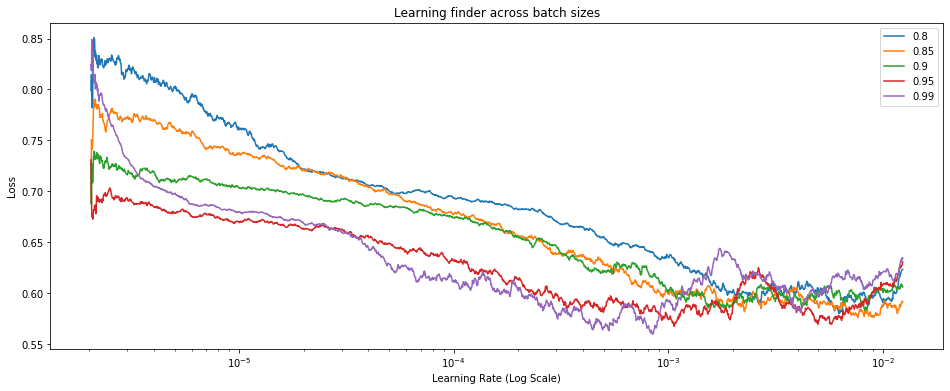

In [187]:
plt.figure(num=None, figsize=(16, 6))

for momentum, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0], lr_losses[1], label= momentum)

plt.legend()
plt.title('Learning finder across batch sizes')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

Optimal momentum is 0.95 with best result at 0.99

### Optimal Weight Decay

In [21]:
def define_model_architecture_64_32_16(weight_decay=1e-2):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(16, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(2, activation='softmax'))
    
    return model

In [8]:
decay_weight_list = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
batch_size = 512
MIN_LR = 2.041943e-06
MAX_LR = 0.0049467864 
MOMENTUM = 0.95
lr_dict = {}

In [9]:
for weight_decay in decay_weight_list:
    print('working with weight_decay : %f' % weight_decay)
    print('-'*120)
    
    model = define_model_architecture_64_32_16(weight_decay)
    sgd_optimizer = optimizers.SGD(lr=6e-3, momentum=MOMENTUM)
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
   
    lrf = LearningRateFinder(model)
    lrf.find(train_batches,MIN_LR, MAX_LR, sampleSize = train_batches.samples, stepsPerEpoch=train_batches.samples/batch_size,
             batchSize=batch_size, verbose=1)
    
    lr_dict[str(weight_decay)] = lrf.get_session_stats()
    print('-'*120)

working with weight_decay : 0.001000
------------------------------------------------------------------------------------------------------------------------
Epoch 1/512


W0913 20:47:04.972732 139996332787520 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


4/3 [=================================] - 1s 234ms/step - loss: 0.9301 - accuracy: 0.5156
Epoch 2/512
4/3 [=================================] - 1s 207ms/step - loss: 0.9663 - accuracy: 0.4688
Epoch 3/512
4/3 [=================================] - 1s 190ms/step - loss: 0.9833 - accuracy: 0.4766
Epoch 4/512
4/3 [=================================] - 1s 179ms/step - loss: 0.9465 - accuracy: 0.4844
Epoch 5/512
4/3 [=================================] - 1s 202ms/step - loss: 0.9598 - accuracy: 0.5078
Epoch 6/512
4/3 [=================================] - 1s 193ms/step - loss: 1.0698 - accuracy: 0.3594
Epoch 7/512
4/3 [=================================] - 1s 265ms/step - loss: 0.9221 - accuracy: 0.5547
Epoch 8/512
4/3 [=================================] - 1s 245ms/step - loss: 0.9095 - accuracy: 0.5625
Epoch 9/512
4/3 [=================================] - 1s 235ms/step - loss: 0.9693 - accuracy: 0.4922
Epoch 10/512
4/3 [=================================] - 1s 230ms/step - loss: 1.0048 - accuracy

KeyboardInterrupt: 

In [ ]:
plt.figure(num=None, figsize=(16, 6))

for decay, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0], lr_losses[1], label= decay)

plt.legend()
plt.title('Learning finder across decay')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

1e-5 is best decay, then 1e-6

In [ ]:
[np.random.uniform(1e-5, 1e-6) for i in range(0,4)]

In [ ]:
decay_weight_list = [7.217819858103498e-06, 1.463012563092303e-06, 1.020575856251244e-06, 7.731861945566172e-06]
batch_size = 512
MIN_LR = 2.041943e-06
MAX_LR = 0.0049467864 
MOMENTUM = 0.95
lr_dict = {}

In [ ]:
for weight_decay in decay_weight_list:
    print('working with weight_decay : %f' % weight_decay)
    print('-'*120)
    
    model = define_model_architecture_64_32_16(weight_decay)
    sgd_optimizer = optimizers.SGD(lr=6e-3, momentum=MOMENTUM)
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
   
    lrf = LearningRateFinder(model)
    lrf.find(train_batches,MIN_LR, MAX_LR, sampleSize = train_batches.samples, stepsPerEpoch=train_batches.samples/batch_size,
             batchSize=batch_size, verbose=1)
    
    lr_dict[str(weight_decay)] = lrf.get_session_stats()
    print('-'*120)

In [ ]:
plt.figure(num=None, figsize=(16, 6))

for decay, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0], lr_losses[1], label= decay)

plt.legend()
plt.title('Learning finder across decay')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

In [ ]:
plt.figure(num=None, figsize=(16, 6))

for batch_size, lr_losses in lr_dict.items():
    plt.plot(lr_losses[0][800:1900], lr_losses[1][800:1900], label= batch_size)

plt.legend()
plt.title('Learning finder across batch sizes')
plt.xscale("log")
plt.xlabel("Learning Rate (Log Scale)")
plt.ylabel("Loss")
plt.show()

select wd  = 1.020575856251244e-06

In [16]:
def define_model_architecture_64_32_16(weight_decay=1e-2):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(16, activation='relu', kernel_regularizer = regularizers.l2(weight_decay)))
    model.add(Dense(2, activation='softmax'))
    
    return model

In [17]:
WEIGHT_DECAY = 1.020575856251244e-06
EPOCHS = 300
BATCH_SIZE = 512

In [18]:
oclr_callback = OneCycleLR(max_lr = 0.3, end_percentage=0.1, scale_percentage=None,
                           maximum_momentum=0.95, minimum_momentum=0.85)
!rm -rf ./logs/

skipLogger_callback = SkipLoggerCallback(n=25)    

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_oclr'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
model = define_model_architecture_64_32_16(WEIGHT_DECAY)
sgd_optimizer = optimizers.SGD(lr=0.0)
model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=BATCH_SIZE, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [21]:
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=1, workers=4,
                              callbacks = [oclr_callback, tb_callback])
    
print('time taken for traning : %.4f' % (time.time() - start))
test_accuracy, test_acc_std_dev = get_oos_test_accuracy(model)
print('Test accuracy: %.4f std dev: %.4f' % (test_accuracy, test_acc_std_dev))    

test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    

num of steps : 3
num of epochs : 300
num of iterations : 1073
mid cycle id : 483 
Epoch 1/300
4/3 [=================================] - 9s 2s/step - loss: 0.8836 - accuracy: 0.3897 - val_loss: 0.7709 - val_accuracy: 0.5514
Epoch 2/300
4/3 [=================================] - 5s 1s/step - loss: 0.6869 - accuracy: 0.5546 - val_loss: 0.7676 - val_accuracy: 0.5536
Epoch 3/300
4/3 [=================================] - 4s 1s/step - loss: 0.6820 - accuracy: 0.5781 - val_loss: 0.7612 - val_accuracy: 0.6083
Epoch 4/300
4/3 [=================================] - 5s 1s/step - loss: 0.6775 - accuracy: 0.5983 - val_loss: 0.7518 - val_accuracy: 0.6368
Epoch 5/300
4/3 [=================================] - 6s 2s/step - loss: 0.6615 - accuracy: 0.6528 - val_loss: 0.7502 - val_accuracy: 0.5908
Epoch 6/300
4/3 [=================================] - 6s 2s/step - loss: 0.6804 - accuracy: 0.5540 - val_loss: 0.7395 - val_accuracy: 0.6193
Epoch 7/300
4/3 [=================================] - 4s 1s/step - loss:

Epoch 33/300
4/3 [=================================] - 5s 1s/step - loss: 0.6459 - accuracy: 0.6490 - val_loss: 0.7341 - val_accuracy: 0.5996
Epoch 34/300
4/3 [=================================] - 6s 2s/step - loss: 0.6563 - accuracy: 0.6212 - val_loss: 0.7192 - val_accuracy: 0.6324
Epoch 35/300
4/3 [=================================] - 6s 2s/step - loss: 0.6123 - accuracy: 0.6998 - val_loss: 0.7243 - val_accuracy: 0.6696
Epoch 36/300
4/3 [=================================] - 5s 1s/step - loss: 0.6677 - accuracy: 0.5966 - val_loss: 0.7078 - val_accuracy: 0.6433
Epoch 37/300
4/3 [=================================] - 6s 2s/step - loss: 0.6031 - accuracy: 0.6840 - val_loss: 0.6912 - val_accuracy: 0.6718
Epoch 38/300
4/3 [=================================] - 5s 1s/step - loss: 0.6252 - accuracy: 0.6583 - val_loss: 0.7026 - val_accuracy: 0.6521
Epoch 39/300
4/3 [=================================] - 7s 2s/step - loss: 0.6138 - accuracy: 0.6659 - val_loss: 0.7648 - val_accuracy: 0.5996
Epoch 

4/3 [=================================] - 7s 2s/step - loss: 0.5955 - accuracy: 0.6812 - val_loss: 0.6799 - val_accuracy: 0.6761
Epoch 66/300
4/3 [=================================] - 5s 1s/step - loss: 0.6371 - accuracy: 0.6408 - val_loss: 0.6730 - val_accuracy: 0.6652
Epoch 67/300
4/3 [=================================] - 6s 2s/step - loss: 0.6008 - accuracy: 0.6709 - val_loss: 0.6640 - val_accuracy: 0.6521
Epoch 68/300
4/3 [=================================] - 6s 1s/step - loss: 0.5961 - accuracy: 0.6938 - val_loss: 0.6659 - val_accuracy: 0.6718
Epoch 69/300
4/3 [=================================] - 5s 1s/step - loss: 0.5884 - accuracy: 0.6850 - val_loss: 0.6620 - val_accuracy: 0.6805
Epoch 70/300
4/3 [=================================] - 6s 1s/step - loss: 0.6282 - accuracy: 0.6157 - val_loss: 0.6794 - val_accuracy: 0.6696
Epoch 71/300
4/3 [=================================] - 7s 2s/step - loss: 0.6084 - accuracy: 0.6692 - val_loss: 0.6602 - val_accuracy: 0.6740
Epoch 72/300
4/3 [=

4/3 [=================================] - 6s 1s/step - loss: 0.5817 - accuracy: 0.6981 - val_loss: 0.7056 - val_accuracy: 0.6608
Epoch 98/300
4/3 [=================================] - 7s 2s/step - loss: 0.6283 - accuracy: 0.6561 - val_loss: 0.6856 - val_accuracy: 0.6761
Epoch 99/300
4/3 [=================================] - 6s 1s/step - loss: 0.6205 - accuracy: 0.6638 - val_loss: 0.6781 - val_accuracy: 0.6696
Epoch 100/300
4/3 [=================================] - 5s 1s/step - loss: 0.5916 - accuracy: 0.6949 - val_loss: 0.6655 - val_accuracy: 0.6761
Epoch 101/300
4/3 [=================================] - 6s 2s/step - loss: 0.5823 - accuracy: 0.6883 - val_loss: 0.7498 - val_accuracy: 0.5536
Epoch 102/300
4/3 [=================================] - 5s 1s/step - loss: 0.6058 - accuracy: 0.6490 - val_loss: 0.6861 - val_accuracy: 0.6696
Epoch 103/300
4/3 [=================================] - 6s 2s/step - loss: 0.6349 - accuracy: 0.6408 - val_loss: 0.6728 - val_accuracy: 0.6696
Epoch 104/300
4

4/3 [=================================] - 6s 1s/step - loss: 0.5933 - accuracy: 0.6823 - val_loss: 0.6761 - val_accuracy: 0.6608
Epoch 130/300
4/3 [=================================] - 5s 1s/step - loss: 0.6066 - accuracy: 0.6856 - val_loss: 0.7221 - val_accuracy: 0.6214
Epoch 131/300
4/3 [=================================] - 7s 2s/step - loss: 0.5869 - accuracy: 0.6796 - val_loss: 0.6655 - val_accuracy: 0.6783
Epoch 132/300
4/3 [=================================] - 5s 1s/step - loss: 0.6175 - accuracy: 0.6621 - val_loss: 0.6523 - val_accuracy: 0.6805
Epoch 133/300
4/3 [=================================] - 5s 1s/step - loss: 0.5621 - accuracy: 0.7031 - val_loss: 0.6838 - val_accuracy: 0.6696
Epoch 134/300
4/3 [=================================] - 6s 2s/step - loss: 0.6019 - accuracy: 0.6834 - val_loss: 0.6923 - val_accuracy: 0.6565
Epoch 135/300
4/3 [=================================] - 6s 1s/step - loss: 0.5825 - accuracy: 0.6916 - val_loss: 0.6856 - val_accuracy: 0.6740
Epoch 136/300

4/3 [=================================] - 6s 1s/step - loss: 0.5794 - accuracy: 0.7031 - val_loss: 0.6347 - val_accuracy: 0.7090
Epoch 162/300
4/3 [=================================] - 6s 2s/step - loss: 0.5456 - accuracy: 0.7052 - val_loss: 0.6273 - val_accuracy: 0.6827
Epoch 163/300
4/3 [=================================] - 5s 1s/step - loss: 0.5752 - accuracy: 0.7041 - val_loss: 0.6607 - val_accuracy: 0.6543
Epoch 164/300
4/3 [=================================] - 7s 2s/step - loss: 0.5701 - accuracy: 0.6927 - val_loss: 0.6312 - val_accuracy: 0.6827
Epoch 165/300
4/3 [=================================] - 5s 1s/step - loss: 0.5529 - accuracy: 0.7129 - val_loss: 0.6993 - val_accuracy: 0.6674
Epoch 166/300
4/3 [=================================] - 6s 1s/step - loss: 0.5757 - accuracy: 0.6932 - val_loss: 0.6167 - val_accuracy: 0.6958
Epoch 167/300
4/3 [=================================] - 6s 1s/step - loss: 0.5755 - accuracy: 0.6927 - val_loss: 0.6303 - val_accuracy: 0.7024
Epoch 168/300

4/3 [=================================] - 5s 1s/step - loss: 0.5612 - accuracy: 0.7031 - val_loss: 0.5982 - val_accuracy: 0.7418
Epoch 194/300
4/3 [=================================] - 7s 2s/step - loss: 0.5269 - accuracy: 0.7374 - val_loss: 0.5887 - val_accuracy: 0.7199
Epoch 195/300
4/3 [=================================] - 6s 1s/step - loss: 0.5434 - accuracy: 0.7151 - val_loss: 0.7157 - val_accuracy: 0.6302
Epoch 196/300
4/3 [=================================] - 5s 1s/step - loss: 0.5669 - accuracy: 0.6883 - val_loss: 0.6243 - val_accuracy: 0.7155
Epoch 197/300
4/3 [=================================] - 5s 1s/step - loss: 0.5256 - accuracy: 0.7385 - val_loss: 0.6021 - val_accuracy: 0.7484
Epoch 198/300
4/3 [=================================] - 5s 1s/step - loss: 0.5662 - accuracy: 0.6949 - val_loss: 0.6577 - val_accuracy: 0.6849
Epoch 199/300
4/3 [=================================] - 7s 2s/step - loss: 0.5411 - accuracy: 0.7112 - val_loss: 0.6032 - val_accuracy: 0.7133
Epoch 200/300

4/3 [=================================] - 5s 1s/step - loss: 0.4914 - accuracy: 0.7604 - val_loss: 0.6011 - val_accuracy: 0.7418
Epoch 226/300
4/3 [=================================] - 6s 1s/step - loss: 0.4899 - accuracy: 0.7718 - val_loss: 0.5878 - val_accuracy: 0.7593
Epoch 227/300
4/3 [=================================] - 6s 1s/step - loss: 0.5073 - accuracy: 0.7576 - val_loss: 0.6196 - val_accuracy: 0.7396
Epoch 228/300
4/3 [=================================] - 7s 2s/step - loss: 0.4901 - accuracy: 0.7822 - val_loss: 0.5624 - val_accuracy: 0.7746
Epoch 229/300
4/3 [=================================] - 6s 2s/step - loss: 0.4811 - accuracy: 0.7800 - val_loss: 0.5586 - val_accuracy: 0.7812
Epoch 230/300
4/3 [=================================] - 5s 1s/step - loss: 0.4788 - accuracy: 0.7757 - val_loss: 0.5518 - val_accuracy: 0.7899
Epoch 231/300
4/3 [=================================] - 6s 2s/step - loss: 0.4795 - accuracy: 0.7773 - val_loss: 0.5950 - val_accuracy: 0.7505
Epoch 232/300

1/3 [=======>......................] - ETA: 4s - loss: 0.4644 - accuracy: 0.7852self.end_lr : 0.030000
current_period : 87.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.024953
self.end_lr : 0.030000
current_period : 86.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.024701
self.end_lr : 0.030000
current_period : 85.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.024449
 - lr: 0.02470 - momentum: 0.95 
4/3 [=================================] - 7s 2s/step - loss: 0.4683 - accuracy: 0.7909 - val_loss: 0.5536 - val_accuracy: 0.7790
Epoch 248/300
self.end_lr : 0.030000
current_period : 84.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.024196
1/3 [=======>......................] - ETA: 3s - loss: 0.4283 - accuracy: 0.8086self.end_lr : 0.030000
current_period : 83.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.023944
self.end_lr : 0.030000
current_period : 82.000000
full_period : 

 - lr: 0.01461 - momentum: 0.95 
4/3 [=================================] - 7s 2s/step - loss: 0.4721 - accuracy: 0.7855 - val_loss: 0.5476 - val_accuracy: 0.8053
Epoch 258/300
self.end_lr : 0.030000
current_period : 44.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.014103
1/3 [=======>......................] - ETA: 0s - loss: 0.4770 - accuracy: 0.7949self.end_lr : 0.030000
current_period : 43.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.013850
self.end_lr : 0.030000
current_period : 42.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.013598
3/3 [========================>.....] - ETA: 0s - loss: 0.4809 - accuracy: 0.7894self.end_lr : 0.030000
current_period : 41.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.013346
 - lr: 0.01360 - momentum: 0.95 
4/3 [=================================] - 5s 1s/step - loss: 0.4714 - accuracy: 0.7888 - val_loss: 0.5199 - val_accuracy: 0.8074
Epoch 259/300
self.end

Epoch 268/300
self.end_lr : 0.030000
current_period : 4.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.004009
1/3 [=======>......................] - ETA: 0s - loss: 0.4337 - accuracy: 0.8311self.end_lr : 0.030000
current_period : 3.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.003757
2/3 [===============>..............] - ETA: 0s - loss: 0.4470 - accuracy: 0.8032self.end_lr : 0.030000
current_period : 2.000000
full_period : 107.000000
percentage_down : 0.000252
new_lr : 0.003505
 - lr: 0.00350 - momentum: 0.95 
4/3 [=================================] - 6s 2s/step - loss: 0.4567 - accuracy: 0.7953 - val_loss: 0.5539 - val_accuracy: 0.7834
Epoch 269/300
4/3 [=================================] - 6s 1s/step - loss: 0.4464 - accuracy: 0.8019 - val_loss: 0.5108 - val_accuracy: 0.8140
Epoch 270/300
4/3 [=================================] - 6s 1s/step - loss: 0.4547 - accuracy: 0.7969 - val_loss: 0.5365 - val_accuracy: 0.7856
Epoch 271/300
4/3 [==

4/3 [=================================] - 6s 1s/step - loss: 0.4599 - accuracy: 0.7931 - val_loss: 0.5430 - val_accuracy: 0.7899
Epoch 299/300
4/3 [=================================] - 6s 2s/step - loss: 0.4481 - accuracy: 0.7942 - val_loss: 0.5522 - val_accuracy: 0.7790
Epoch 300/300
4/3 [=================================] - 5s 1s/step - loss: 0.4558 - accuracy: 0.7997 - val_loss: 0.5554 - val_accuracy: 0.7593
time taken for traning : 1750.2748
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2

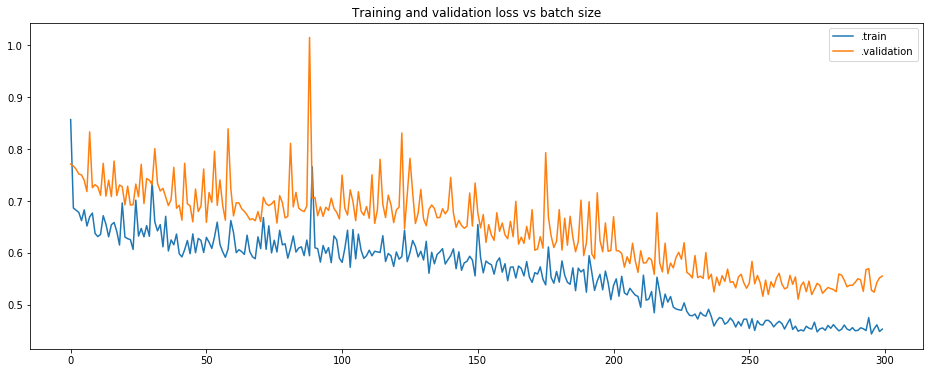

In [22]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history.history['loss'], label= '.train')
plt.plot(history.history['val_loss'], label= '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
#plt.xlim(0, EPOCHS)
plt.show()

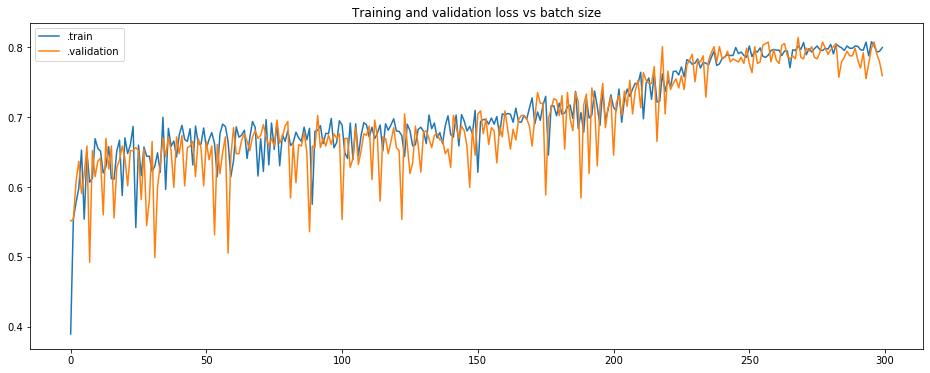

In [23]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history.history['accuracy'], label= '.train')
plt.plot(history.history['val_accuracy'], label= '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.show()

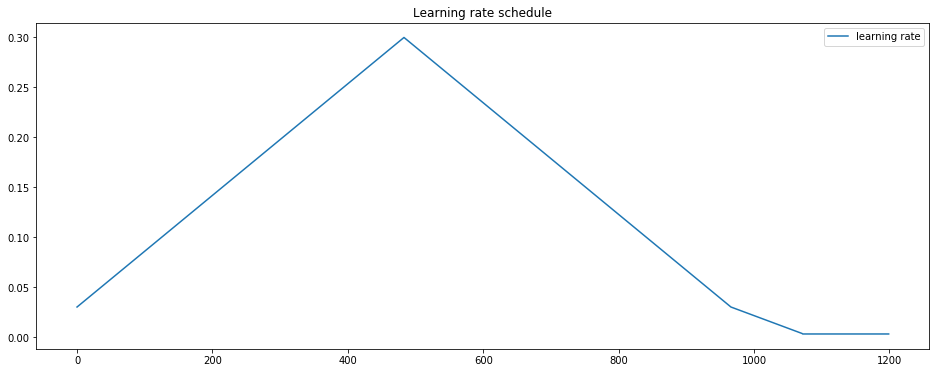

In [24]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(oclr_callback.history['lr'], label= 'learning rate')

plt.legend()
plt.title('Learning rate schedule')
plt.show()

1. max_lr = 0.0049467864, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.6379
2. max_lr = 0.01, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.7183
3. max_lr = 0.01, maximum_momentum=0.95, minimum_momentum=0.85, epochs=100 : 0.6743
4. max_lr = 0.05, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.7266
5. max_lr = 0.09, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.7366
6. max_lr = 0.1, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.7779
7. max_lr = 0.3, maximum_momentum=0.99, minimum_momentum=0.9, epochs=100 : 0.7179
8. max_lr = 0.3, maximum_momentum=0.99, minimum_momentum=0.9, epochs=200 : 0.8088
9. max_lr = 0.3, maximum_momentum=0.95, minimum_momentum=0.85, epochs=200 : 0.7885